In [1]:
import sys
sys.path.append('..')

# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d as td
from pepper import SimulationFdfd, PlaneWaveFdfd, GaussianBeamFdfd

[13:33:45] INFO     Using client version: 1.9.1                                                     ]8;id=64165;file:///Users/lucasgrosjean/.pyenv/versions/3.11.2/envs/pepper/lib/python3.11/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=450133;file:///Users/lucasgrosjean/.pyenv/versions/3.11.2/envs/pepper/lib/python3.11/site-packages/tidy3d/__init__.py#115\115]8;;\

In [2]:
# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# # compute quantities based on geometry parameters
# x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
# y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
# wg_insert_x = ring_radius + wg_spacing
# wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.
# compute quantities based on geometry parameters
x_span = 2*wg_spacing + buffer
y_span = ring_radius + buffer
wg_insert_x = wg_spacing
wg_center_y = 0#ring_radius + couple_width + wg_width/2.

In [3]:
# wavelength range of interest
lambda_beg = 0.4
lambda_end = 0.6

# define pulse parameters
freq_beg = td.C_0 / lambda_end
freq_end = td.C_0 / lambda_beg
freq0 = (freq_beg + freq_end) / 2
fwidth = (freq_end - freq0) / 1.5

min_steps_per_wvl = 30
run_time = 1e-11

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

In [5]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

In [6]:
# x_span *= 3
# y_span *= 3

pw_fdfd = GaussianBeamFdfd(
    size=[td.inf,0,td.inf],
    center=(0, -y_span/4, 0),
    wavelength=1.55*1e-6,
    angle_theta=np.pi/4,
    angle_phi=0.0,
    direction='+',
    waist_radius=1.,
)

gauss_fdfd = GaussianBeamFdfd(
    size=[0, 2 , 1],
    center=(-x_span/4, 0, 0.1),
    angle_theta=0.3,
    angle_phi=0.0,
    direction='+',
    wavelength=1.55*1e-6,
)

bloch_x = td.Boundary.bloch_from_source(
    pw_fdfd,
    domain_size=x_span,
    axis=0)

sim_pw_fdfd = SimulationFdfd(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    # structures=[background_box, waveguide],
    structures=[background_box],
    sources=[pw_fdfd],
    polarization='TE',
    #monitors=[field_monitor, mode_monitor],
    #run_time = 1,
    # boundary_spec=td.BoundarySpec(x=bloch_x, y=td.Boundary.pml(), z=td.Boundary.periodic()),
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()),
    tfsf=False
)


sim_fdfd = SimulationFdfd(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    # structures=[background_box, waveguide],
    structures=[background_box],
    sources=[gauss_fdfd],
    polarization='TE',
    #monitors=[field_monitor, mode_monitor],
    #run_time = 1,
    # boundary_spec=td.BoundarySpec(x=bloch_x, y=td.Boundary.pml(), z=td.Boundary.periodic()),
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()),
    tfsf=True
)

In [7]:
sim_fdfd.grid_spec

GridSpec(grid_x=UniformGrid(type='UniformGrid', dl=0.03), grid_y=UniformGrid(type='UniformGrid', dl=0.03), grid_z=UniformGrid(type='UniformGrid', dl=0.03), wavelength=None, override_structures=(), type='GridSpec')

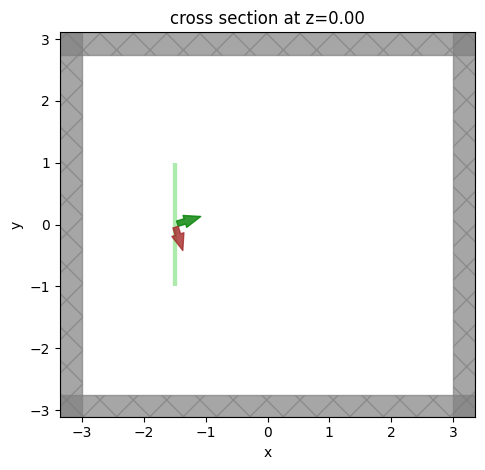

In [8]:
sim_fdfd.plot(z=0);

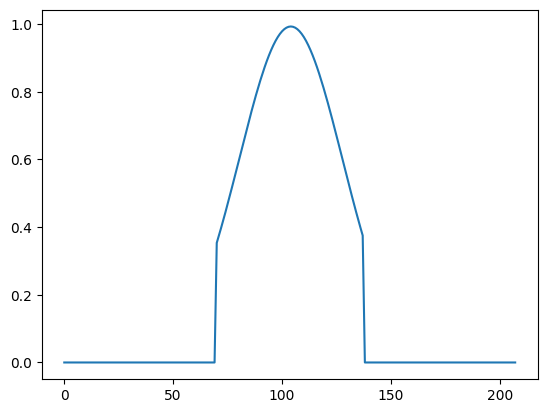

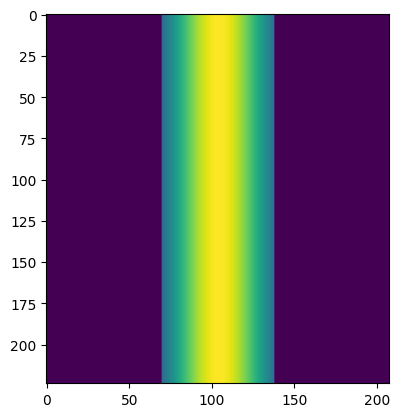

AttributeError: 'NoneType' object has no attribute 'ndim'

In [9]:
plt.imshow(np.real(sim_fdfd.run()).T, origin='lower');

In [ ]:
plt.imshow(np.abs(sim_fdfd.source[0].reshape(sim_fdfd.grid.num_cells).squeeze()).T, origin='lower')

(68, 1) (1, 68, 1) (68,)


AttributeError: module 'numpy' has no attribute '_ix'

In [ ]:
pw_fdfd2 = PlaneWaveFdfd(
    size=[0, td.inf ,td.inf],
    center=(-x_span/4, 0, 0),
    wavelength=1.55*1e-6,
    angle_theta=0.3,
    angle_phi=0.0,
    direction='+',
)

bloch_y = td.Boundary.bloch_from_source(
    pw_fdfd2,
    domain_size=y_span,
    axis=1)

sim_fdfd2 = SimulationFdfd(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    # structures=[background_box, waveguide],
    structures=[background_box],
    sources=[pw_fdfd2],
    polarization='TE',
    #monitors=[field_monitor, mode_monitor],
    #run_time = 1,
    tfsf = True,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=bloch_y, z=td.Boundary.periodic()),
)

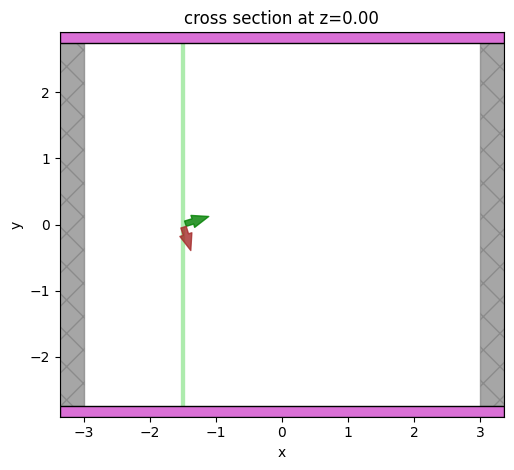

In [ ]:
sim_fdfd2.plot(z=0);

In [ ]:
# plt.imshow(np.real(sim_fdfd2.run()).T, origin='lower');

In [ ]:
gauss = td.GaussianBeam(
    size=[0, 2 , 1],
    source_time=td.GaussianPulse(freq0=sim_fdfd.freq0, fwidth=0.1*sim_fdfd.freq0),
    center=(-x_span/4, 0, 0.1),
    angle_theta=0.3,
    angle_phi=0.0,
    direction='+',
)

bloch_y = td.Boundary.bloch_from_source(
    pw_fdfd2,
    domain_size=y_span,
    axis=1)

sim3d = td.Simulation(
    size=[x_span, y_span, 2],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    # structures=[background_box, waveguide],
    structures=[background_box],
    sources=[gauss],
    #monitors=[field_monitor, mode_monitor],
    run_time = 1,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=bloch_y, z=td.Boundary.periodic()),
)

sim2d = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    # structures=[background_box, waveguide],
    structures=[background_box],
    sources=[gauss],
    #monitors=[field_monitor, mode_monitor],
    run_time = 1,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=bloch_y, z=td.Boundary.periodic()),
)

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

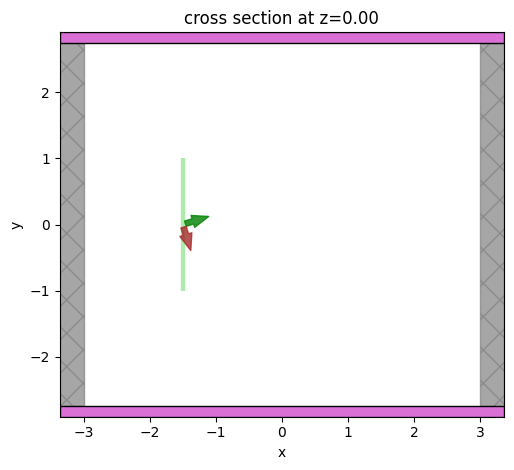

In [ ]:
sim3d.plot(z=0)

<Axes: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

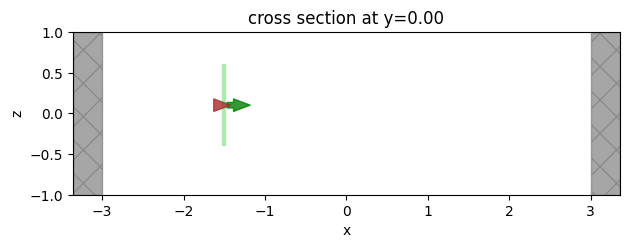

In [ ]:
sim3d.plot(y=0)

In [ ]:
sim3d.discretize(gauss).boundaries.to_list

[array([-1.5 , -1.47]),
 array([-1.01630435, -0.98641304, -0.95652174, -0.92663043, -0.89673913,
        -0.86684783, -0.83695652, -0.80706522, -0.77717391, -0.74728261,
        -0.7173913 , -0.6875    , -0.6576087 , -0.62771739, -0.59782609,
        -0.56793478, -0.53804348, -0.50815217, -0.47826087, -0.44836957,
        -0.41847826, -0.38858696, -0.35869565, -0.32880435, -0.29891304,
        -0.26902174, -0.23913043, -0.20923913, -0.17934783, -0.14945652,
        -0.11956522, -0.08967391, -0.05978261, -0.0298913 ,  0.        ,
         0.0298913 ,  0.05978261,  0.08967391,  0.11956522,  0.14945652,
         0.17934783,  0.20923913,  0.23913043,  0.26902174,  0.29891304,
         0.32880435,  0.35869565,  0.38858696,  0.41847826,  0.44836957,
         0.47826087,  0.50815217,  0.53804348,  0.56793478,  0.59782609,
         0.62771739,  0.6576087 ,  0.6875    ,  0.7173913 ,  0.74728261,
         0.77717391,  0.80706522,  0.83695652,  0.86684783,  0.89673913,
         0.92663043,  0.956

In [ ]:
gauss.pop_axis(sim3d.discretize(gauss).yee.E.z.to_list, axis=gauss.injection_axis)

(array([-1.5]),
 (array([-1.01630435, -0.98641304, -0.95652174, -0.92663043, -0.89673913,
         -0.86684783, -0.83695652, -0.80706522, -0.77717391, -0.74728261,
         -0.7173913 , -0.6875    , -0.6576087 , -0.62771739, -0.59782609,
         -0.56793478, -0.53804348, -0.50815217, -0.47826087, -0.44836957,
         -0.41847826, -0.38858696, -0.35869565, -0.32880435, -0.29891304,
         -0.26902174, -0.23913043, -0.20923913, -0.17934783, -0.14945652,
         -0.11956522, -0.08967391, -0.05978261, -0.0298913 ,  0.        ,
          0.0298913 ,  0.05978261,  0.08967391,  0.11956522,  0.14945652,
          0.17934783,  0.20923913,  0.23913043,  0.26902174,  0.29891304,
          0.32880435,  0.35869565,  0.38858696,  0.41847826,  0.44836957,
          0.47826087,  0.50815217,  0.53804348,  0.56793478,  0.59782609,
          0.62771739,  0.6576087 ,  0.6875    ,  0.7173913 ,  0.74728261,
          0.77717391,  0.80706522,  0.83695652,  0.86684783,  0.89673913,
          0.92663043, 

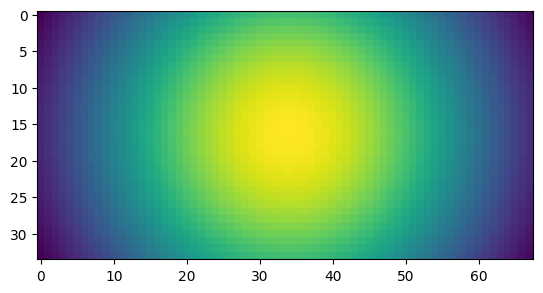

In [ ]:
_, coords = gauss.pop_axis(sim3d.discretize(gauss).yee.E.z.to_list, axis=gauss.injection_axis)
_, center = gauss.pop_axis(gauss.center, axis=gauss.injection_axis)

coords = [coords[i] - center[i] for i in range(len(center))]

ii, jj = np.meshgrid(*coords)
plt.imshow(np.exp(-ii**2 - jj**2))

In [ ]:
indices = [np.arange(*val) for val in sim2d.grid.discretize_inds(gauss)]
test = np.ones(sim2d.grid.num_cells)
print(indices)

[array([62]), array([ 58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125]), array([0])]


In [ ]:
test[*indices] = 3

In [ ]:
# plt.imshow(test)

In [ ]:
sim3d.pop_axis(sim3d.grid.num_cells, axis=gauss.injection_axis)

(224, (184, 67))

In [ ]:
sim3d.grid.num_cells

[224, 184, 67]

In [ ]:
sim3d.grid.discretize_inds(gauss)

[(62, 63), (58, 126), (20, 54)]

In [ ]:
coords

[array([-1.01630435, -0.98641304, -0.95652174, -0.92663043, -0.89673913,
        -0.86684783, -0.83695652, -0.80706522, -0.77717391, -0.74728261,
        -0.7173913 , -0.6875    , -0.6576087 , -0.62771739, -0.59782609,
        -0.56793478, -0.53804348, -0.50815217, -0.47826087, -0.44836957,
        -0.41847826, -0.38858696, -0.35869565, -0.32880435, -0.29891304,
        -0.26902174, -0.23913043, -0.20923913, -0.17934783, -0.14945652,
        -0.11956522, -0.08967391, -0.05978261, -0.0298913 ,  0.        ,
         0.0298913 ,  0.05978261,  0.08967391,  0.11956522,  0.14945652,
         0.17934783,  0.20923913,  0.23913043,  0.26902174,  0.29891304,
         0.32880435,  0.35869565,  0.38858696,  0.41847826,  0.44836957,
         0.47826087,  0.50815217,  0.53804348,  0.56793478,  0.59782609,
         0.62771739,  0.6576087 ,  0.6875    ,  0.7173913 ,  0.74728261,
         0.77717391,  0.80706522,  0.83695652,  0.86684783,  0.89673913,
         0.92663043,  0.95652174,  0.98641304]),
 a

(68, 1) (1, 68, 1) (68,)


(68, 1)
(1, 68, 1)


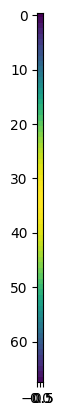

In [ ]:
_, coords = gauss.pop_axis(sim2d.discretize(gauss).yee.E.z.to_list, axis=gauss.injection_axis)
_, center = gauss.pop_axis(gauss.center, axis=gauss.injection_axis)

coords = [coords[i] - center[i] for i in range(len(center))]

ii, jj = np.meshgrid(*coords, indexing='ij')
beam = np.exp(-ii**2 - jj**2)
plt.imshow(beam);

print(beam.shape)
# print(np.atleast_3d(beam).shape)
# beam = np.moveaxis(np.atleast_3d(beam), source=0, destination=gauss.injection_axis)
# print(beam.shape)

src_value = np.zeros(sim2d.grid.num_cells)

indices = [np.arange(*val) for val in sim2d.grid.discretize_inds(gauss)]
src_value[np.ix_(*indices)] = beam

print(src_value[np.ix_(*indices)].shape)

In [ ]:
[np.arange(*val) for val in gauss.pop_axis(sim2d.grid.discretize_inds(gauss), axis=gauss.injection_axis)[1]]

[array([ 58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125]),
 array([0])]

(184, 1) [array([ 58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125]), array([0])] (68, 1)


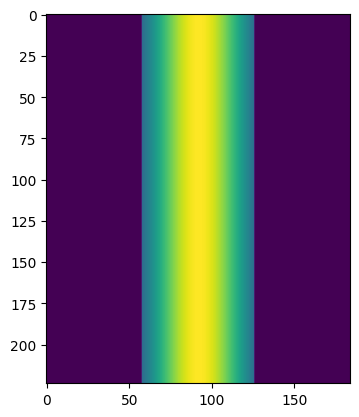

In [ ]:
num_cell, num_cells_src = gauss.pop_axis(sim2d.grid.num_cells, axis=gauss.injection_axis)

# src2d = np.moveaxis(np.stack([beam] * num_cell), source=0, destination=gauss.injection_axis)
# src3d = np.moveaxis(np.stack([src_slice] * num_cell), source=0, destination=gauss.injection_axis)

src_slice = np.zeros(num_cells_src)
print(src_slice.shape,[np.arange(*val) for val in gauss.pop_axis(sim2d.grid.discretize_inds(gauss), axis=gauss.injection_axis)[1]], beam.shape)
src_slice[np.ix_(*[np.arange(*val) for val in gauss.pop_axis(sim2d.grid.discretize_inds(gauss), axis=gauss.injection_axis)[1]])] = beam
src2d = np.moveaxis(np.stack([src_slice] * num_cell), source=0, destination=gauss.injection_axis)

# print(src2d.shape, sim2d.grid.num_cells)
plt.imshow(src2d);

(68,)
(68, 34)
(68, 34)


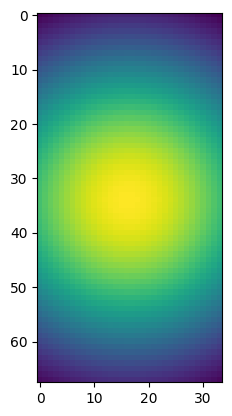

In [ ]:
_, coords = gauss.pop_axis(sim3d.discretize(gauss).yee.E.z.to_list, axis=gauss.injection_axis)
_, center = gauss.pop_axis(gauss.center, axis=gauss.injection_axis)

coords = [coords[i] - center[i] for i in range(len(center))]
print(coords[0].shape)
ii, jj = np.meshgrid(*coords, indexing='ij')
print(ii.shape)
beam = np.exp(-ii**2 - jj**2)
plt.imshow(beam);

print(beam.shape)
# print(np.atleast_3d(beam).shape)
# beam = np.moveaxis(np.atleast_3d(beam), source=0, destination=gauss.injection_axis)
# print(beam.shape)

src_value = np.zeros(sim3d.grid.num_cells)

indices = [np.arange(*val) for val in sim3d.grid.discretize_inds(gauss)]
src_value[np.ix_(*indices)] = beam

In [ ]:
print(src_value[np.ix_(*indices)].shape)

(1, 68, 34)


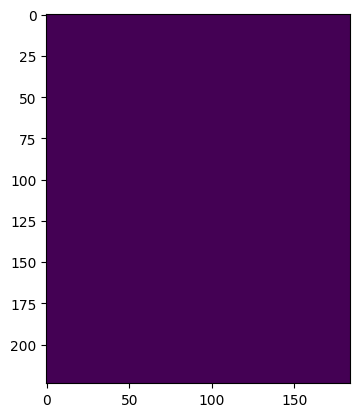

In [ ]:
plt.imshow(src_value[:,100,:]);
plt.imshow(src_value[:,:,10]);

(184, 67) [array([ 58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125]), array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53])] (68, 34)


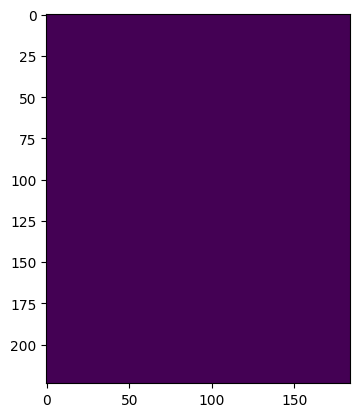

In [ ]:
num_cell, num_cells_src = gauss.pop_axis(sim3d.grid.num_cells, axis=gauss.injection_axis)

# src2d = np.moveaxis(np.stack([beam] * num_cell), source=0, destination=gauss.injection_axis)
# src3d = np.moveaxis(np.stack([src_slice] * num_cell), source=0, destination=gauss.injection_axis)

src_slice = np.zeros(num_cells_src)
print(src_slice.shape,[np.arange(*val) for val in gauss.pop_axis(sim3d.grid.discretize_inds(gauss), axis=gauss.injection_axis)[1]], beam.shape)
src_slice[np.ix_(*[np.arange(*val) for val in gauss.pop_axis(sim3d.grid.discretize_inds(gauss), axis=gauss.injection_axis)[1]])] = beam
src3d = np.moveaxis(np.stack([src_slice] * num_cell), source=0, destination=gauss.injection_axis)

# print(src2d.shape, sim2d.grid.num_cells)
plt.imshow(src3d[:,:,10]);

In [ ]:
[np.arange(*val) for val in sim3d.grid.discretize_inds(gauss)]
sim3d.grid.num_cells, src3d.shape

([224, 184, 67], (224, 184, 67))

TypeError: Invalid shape (1, 68, 34) for image data

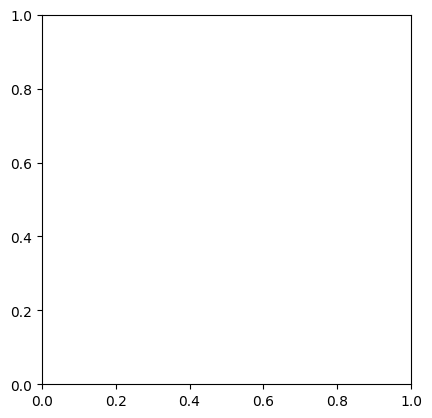

In [ ]:
# src_indices = 
plt.imshow(src_value[np.ix_(*[np.arange(*val) for val in sim3d.grid.discretize_inds(gauss)])])

In [ ]:
src2d = np.moveaxis(np.stack([src_slice] * num_cell), source=0, destination=gauss.injection_axis)

In [ ]:
num_cell, num_cells_src = gauss.pop_axis(sim.grid.num_cells, axis=gauss.injection_axis)

src_slice = np.zeros(num_cells_src)
src_slice[*[np.arange(*val) for val in gauss.pop_axis(sim.grid.discretize_inds(gauss), axis=gauss.injection_axis)[1]]] = beam
src3d = np.moveaxis(np.stack([src_slice] * num_cell), source=0, destination=gauss.injection_axis)

NameError: name 'sim' is not defined

In [ ]:
sim.grid.discretize_inds(gauss)

[(62, 63), (80, 104), (6, 19)]

In [ ]:
src_value.shape

(224, 184, 23)

In [ ]:
src_value[idx, idy, idz] = np.moveaxis(np.atleast_3d(beam),source=0,destination=gauss.injection_axis)

NameError: name 'idx' is not defined

In [ ]:
src_value[idx[:, np.newaxis], idy[:, np.newaxis], idz] = beam

In [ ]:
src_value[idx, idy, idz].shape

(23,)

In [ ]:
src3d = np.zeros(sim.grid.num_cells)

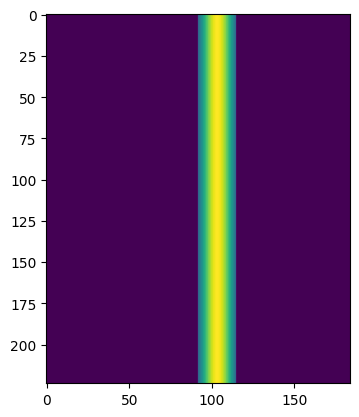

In [ ]:
plt.imshow(src3d.squeeze());

In [ ]:
gauss.pop_axis(sim.grid.discretize_inds(gauss), axis=gauss.injection_axis)[1]

((92, 115), (0, 23))